In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df=pd.read_csv("./data/TG_STAID002759.txt", parse_dates=True, index_col=1)
df.rename(columns = {' SOUID': 'source', '   TG':"temp", ' Q_TG': 'QTG'}, inplace=True)

In [3]:
missing = pd.date_range('1945-04-25', periods=195, freq='D')  # solution for loops from Aron
year44 = pd.date_range('1944-04-25', periods=195, freq='D')
year46 = pd.date_range('1946-04-25', periods=195, freq='D')
m=0
for i in tqdm(missing):
    df.loc[i,"temp"] = (df.loc[year44[m]]["temp"] + df.loc[year46[m]]["temp"]) / 2
    m += 1

In [4]:
df['tempK']=df['temp']*0.1+273.15 #Kelvin
df=df.drop(['QTG', 'source','temp'],axis=1) #removing all unnecessary columns
df = df[~((df.index.month == 2) & (df.index.day == 29))] #removing all 29 February

#### Decomposing

In [5]:
def decompose(df):
   
    df['diff_temp']=df['tempK'].diff() #trend
    df['monthly_mean'] = df.groupby(df.index.month)['diff_temp'].transform('mean')  #seasonality
    df['stationary_temp'] = df.diff_temp - df.monthly_mean  #noise

    return df

In [6]:
decompose(df).head(5)

,tempK,diff_temp,monthly_mean,stationary_temp
DATE,,,,
1876-01-01,275.35,NaN,-0.005496,NaN
1876-01-02,275.65,0.3,-0.005496,0.305496
1876-01-03,273.45,-2.2,-0.005496,-2.194504
1876-01-04,267.35,-6.1,-0.005496,-6.094504
1876-01-05,263.35,-4.0,-0.005496,-3.994504


#### Train/Test Split

In [7]:
train = df.iloc[-3650:-365]['stationary_temp'] #2010-08-01 - 2020-07-24
test = df.iloc[-365:]['stationary_temp']      #2020-07-25 - 2020-07-31

#### ARIMA testing

In [22]:
m = ARIMA(train, order=(1,0,3))

/Users/madinamukhambekova/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [23]:
m_fit = m.fit()

In [10]:
future = m_fit.forecast(steps=365)[0] 

In [27]:
year = 1
y_future = pd.DataFrame(index = pd.date_range(start='31 July 2020', periods = 365*year, freq='D'),
             data=[0]*365*year,
             columns=['monthly_mean'])

In [31]:
original=df.iloc[-365:]
y_future.iloc[0, 0] = df_train.tempK[-1]
mean_train=original.groupby(original.index.month)['diff_temp'].transform('mean')

In [66]:
y_future.iloc[1:] = mean_train[0:(365*year)-1].values.reshape(-1,1)
prediction=pd.DataFrame(future, index=y_future.index, columns=['forecast'])
pred = pd.concat([prediction, y_future], axis=1)
pred['reseasoned']=pred.forecast + pred.monthly_mean 
pred['prediction'] = np.cumsum(pred.reseasoned)

Text(0.5, 1.0, 'Prediction with ARIMA from 31 July 2020 to 31 July 2021')

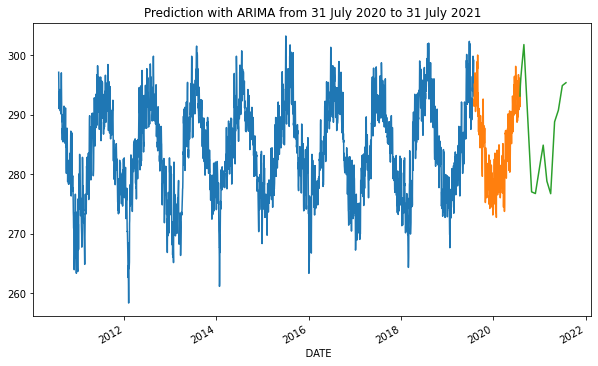

In [65]:
df.iloc[-3650:-365]['tempK'].plot()
df.iloc[-365:]['tempK'].plot()
pred['prediction'].plot()
plt.title('Prediction with ARIMA from 31 July 2020 to 31 July 2021')